In [1]:
from os.path import dirname, abspath,join
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from typing import List

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from proT.predict import *

## External Dataset

In [2]:
datadir_path = r"../data/input"
config_path = r"../experiments/training/InnosuisseMS_Ent_ON/config_proT_dyconex_v5_5.yaml"
checkpoint_path = r"../experiments/training/InnosuisseMS_Ent_ON/k_3/checkpoints/best_checkpoint.ckpt"

# config_path = r"../experiments/training/InnosuisseMS_Ent_OFF/config_proT_dyconex_v5_5.yaml"
# checkpoint_path = r"../experiments/training/InnosuisseMS_Ent_OFF/k_3/checkpoints/best_checkpoint.ckpt"

config = OmegaConf.load(config_path)

In [43]:
show_trg_max_idx = 60.0
input_array, output_array, target_array, cross_att_array, enc_self_att_array, dec_self_att_array = predict_test_from_ckpt(
    config, 
    datadir_path, 
    checkpoint_path, 
    external_dataset=None,
    dataset_label="test",
    show_trg_max_idx = show_trg_max_idx,
    cluster=False
    )
print(f"predicted {len(output_array)} curves!")
output_array.shape

Global seed set to 42
c:\ProgramData\anaconda3\envs\prochain_transformer\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.0.3
  rank_zero_warn(


Test dataset selected (default).
Predicting...


100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


predicted 4 curves!


(4, 400, 2)

In [44]:
# files
dataset_name = config["data"]["dataset"][3:]
builds_dir = "../../process_pipeline/data/builds"
var_vocab_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_trg")
var_vocab_input_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_input")
pos_vocab_filepath = join(builds_dir, dataset_name, "output/position_vocabulary.json")
group_vocab_filepath = join(builds_dir, dataset_name, "output/batch_vocabulary.json")
rating_filepath = join(builds_dir, dataset_name, "control/steps_selected.xlsx")

with open(var_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_var_dict = json.load(file)
    
with open(var_vocab_input_filepath, 'r', encoding='utf-8') as file:
    inv_var_input_dict = json.load(file)
    
with open(pos_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_pos_dict = json.load(file)
    
with open(group_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_group_dict = json.load(file)

df_rating = pd.read_excel(rating_filepath)

# maps
var_map = {v: k[:3] for k, v in inv_var_dict.items()}
var_input_map = {v: k for k, v in inv_var_input_dict.items()}
pos_map = {v: int(float(k)) for k, v in inv_pos_dict.items()}
group_map = {v: k for k, v in inv_group_dict.items()}
rate_map = df_rating.set_index("Step")["Bewertung "].to_dict()
process_map = df_rating.set_index("Step")["Process"].to_dict()


# define data indices
var_index = 2
x_index = 3
val_index = 4

# get variables
vars = np.unique(target_array[:,:,var_index])
vars = vars[~np.isnan(vars)]
num_vars = len(vars)

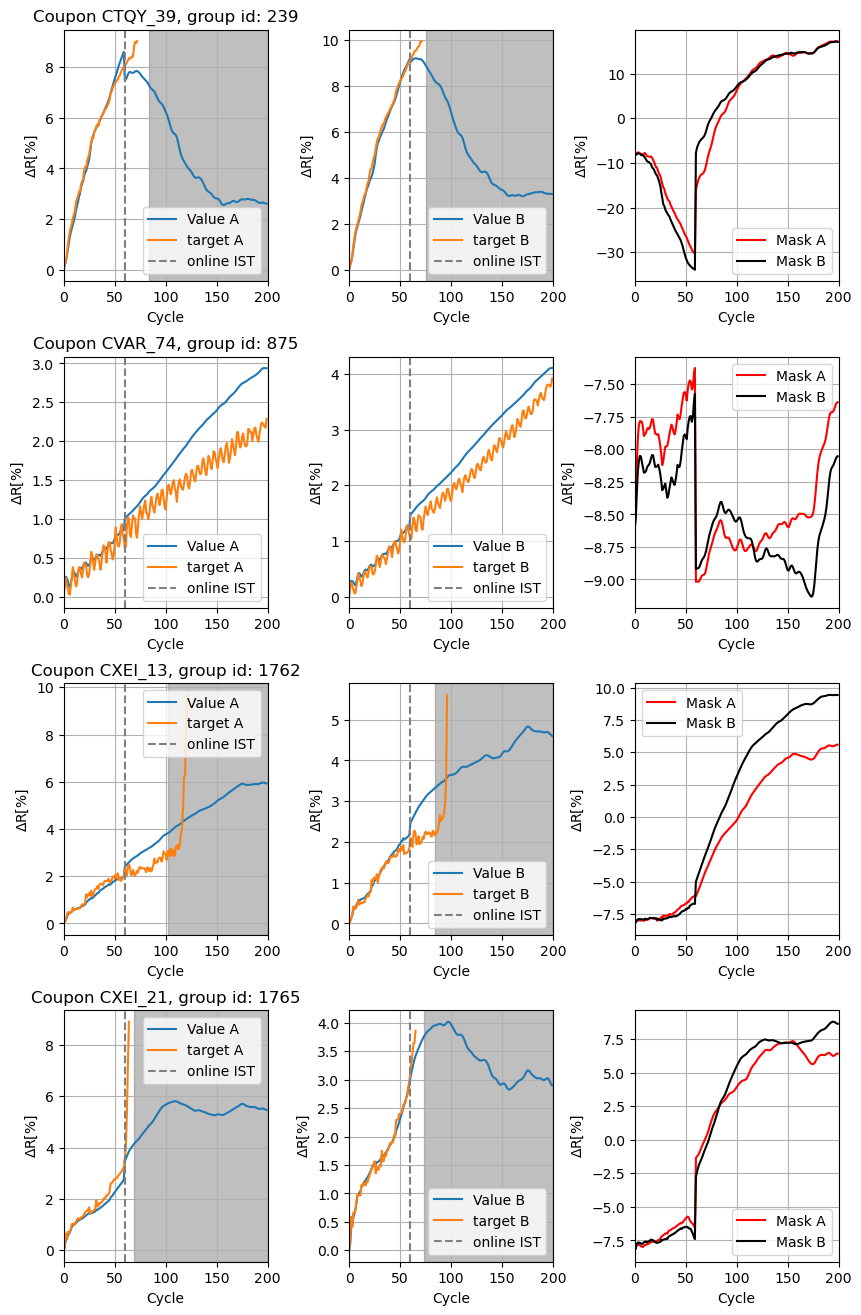

In [45]:
plot_target = True
n_samples = len(output_array)
vars = np.delete(np.unique(np.nan_to_num(target_array[:,:,2])),0)

fig = plt.figure(figsize=(10,n_samples*4))

g = gridspec.GridSpec(
    nrows=n_samples,
    ncols=3,
    hspace=.3,
    wspace=.4
)
for i in range(n_samples):
    ax_val_A = fig.add_subplot(g[i,0])
    ax_val_B = fig.add_subplot(g[i,1])
    ax_m = fig.add_subplot(g[i,2])
    
    # prediction
    ax_val_A.plot(output_array[i,:200,0]*10, label="Value A")
    if plot_target:
        ax_val_A.plot(target_array[i,:200,4]*10, label="target A")
        
    # online IST
    if show_trg_max_idx is not None:
        ax_val_A.axvline(show_trg_max_idx, color='gray', linestyle='--', label='online IST')
        
    # Find breaking region Sense A
    boolean_array = output_array[i,:200,1] > 0
    start_indices = np.where(np.diff(np.concatenate(([False], boolean_array))))[0]
    if np.size(start_indices)==0:
        start_indices=200
    else:
        start_indices = start_indices[0]
    ax_val_A.axvspan(start_indices, 200, color='gray', alpha=0.5)
    
    # prediction
    ax_val_B.plot(output_array[i,200:,0]*10, label="Value B")
    if plot_target:
        ax_val_B.plot(target_array[i,200:,4]*10, label="target B")
        
    # online IST
    if show_trg_max_idx is not None:
        ax_val_B.axvline(show_trg_max_idx, color='gray', linestyle='--', label='online IST')
    
    # Find breaking region Sense B
    boolean_array = output_array[i,200:,1] > 0
    start_indices = np.where(np.diff(np.concatenate(([False], boolean_array))))[0]
    if np.size(start_indices)==0:
        start_indices=200
    else:
        start_indices = start_indices[0]
    ax_val_B.axvspan(start_indices, 200, color='gray', alpha=0.5)
    
    
    ax_m.plot(output_array[i,:200,1], label="Mask A", color="red")
    ax_m.plot(output_array[i,200:,1], label="Mask B", color = "black")
    
    coupon_group_id = target_array[i,0,0]
    
    ax_val_A.set_title(f"Coupon {group_map[coupon_group_id]}, group id: {int(coupon_group_id)}")
    for ax in [ax_val_A, ax_val_B, ax_m]:
        ax.legend()
        ax.grid(True)
        ax.set_ylabel(r"$\Delta$R[%]")
        ax.set_xlabel("Cycle")
        ax.set_xlim(0,200)
    
plt.show()

In [7]:
dec_self_att_array.sum(axis=1).shape

(4, 400, 400)

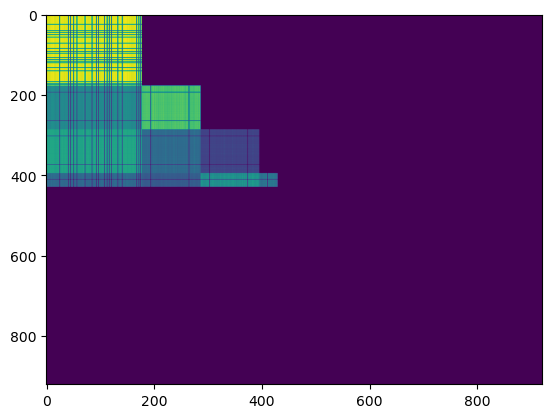

In [8]:
plt.imshow(enc_self_att_array.sum(axis=1)[1,:,:], aspect='auto', cmap='viridis')

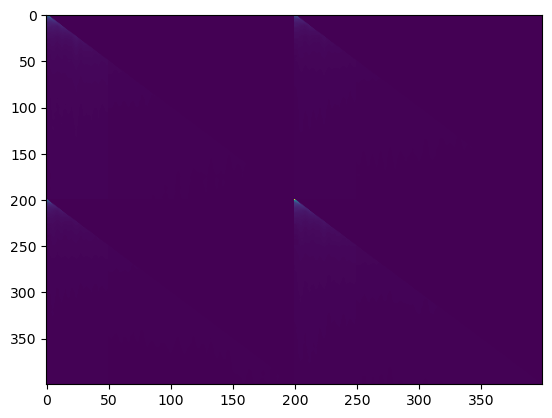

In [9]:
plt.imshow(dec_self_att_array.sum(axis=1)[1,:,:], aspect='auto', cmap='viridis')

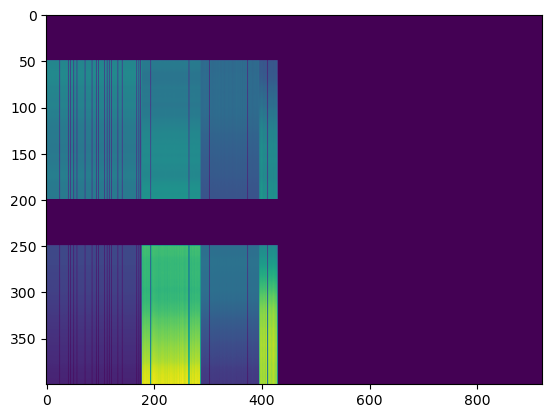

In [10]:
plt.imshow(cross_att_array.sum(axis=1)[1,:,:], aspect='auto', cmap='viridis')

In [55]:
df = pd.read_csv("../experiments/training/InnosuisseMS_Ent_ON/k_3/logs/csv/version_0/metrics.csv")
df.head()

,epoch,step,test_dec_cross_entropy,test_dec_self_entropy,test_enc_self_entropy,test_loss,test_mae,test_r2,test_rmse,train_dec_cross_entropy,...,train_mae,train_r2,train_rmse,val_dec_cross_entropy,val_dec_self_entropy,val_enc_self_entropy,val_loss,val_mae,val_r2,val_rmse
0,0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.573186,4.286515,3.733416,0.110254,0.243553,-3.701253,0.315327
1,0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.585305,...,0.876829,-121.50547,1.074062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.489293,4.339653,3.215178,0.013408,0.063346,0.672412,0.087245
3,1,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.584210,...,0.094964,0.40693,0.121746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.892396,4.444733,3.515009,0.019306,0.099790,0.371983,0.121111


(0.0, 0.2)

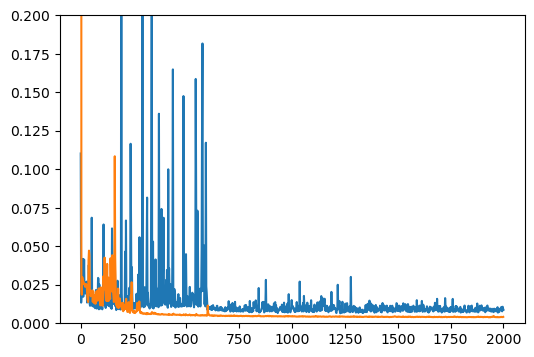

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df["val_loss"].dropna())
ax.plot(df["train_loss"].dropna())
ax.set_ylim(0, 0.2)

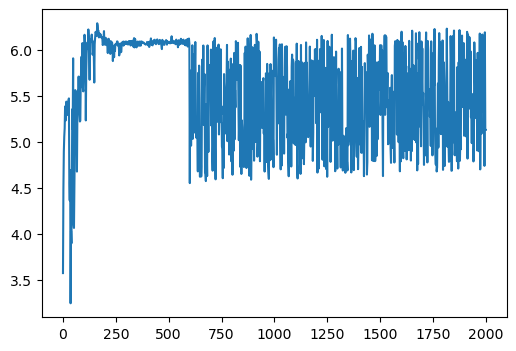

In [57]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df["val_dec_cross_entropy"].dropna())

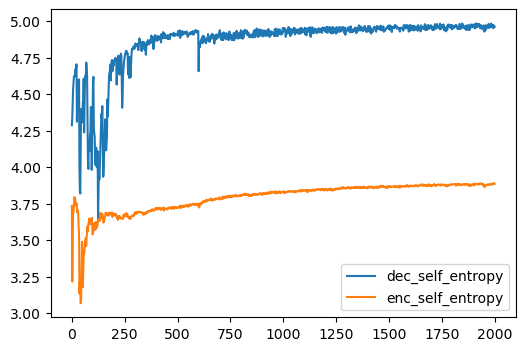

In [58]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df["val_dec_self_entropy"].dropna(), label="dec_self_entropy")
ax.plot(df["val_enc_self_entropy"].dropna(), label="enc_self_entropy")
ax.legend()